In [67]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import  train_test_split 
import math
from tensorflow.keras.utils import to_categorical
import os
import cv2


In [68]:
cat_path = "datasett-hundogkatt/training_set/training_set/cats/"
dog_path = "datasett-hundogkatt/training_set/training_set/dogs/"

In [69]:
cat_img = []
for i in os.listdir(cat_path):
    if i.endswith(".jpg"):
        temp_img = cv2.imread(os.path.join(cat_path, i), cv2.IMREAD_GRAYSCALE)
        temp_img = cv2.resize(temp_img, (128,128), interpolation= cv2.INTER_LINEAR )
        cat_img.append(temp_img)

In [70]:
cat_img = np.asarray(cat_img)
cat_img = np.expand_dims(cat_img,-1)

In [71]:
y_cat = np.zeros(cat_img.shape[0])

In [72]:
dog_img = []
for i in os.listdir(dog_path):
    if i.endswith(".jpg"):
        temp_img = cv2.imread(os.path.join(dog_path, i), cv2.IMREAD_GRAYSCALE)
        temp_img = cv2.resize(temp_img, (128,128), interpolation= cv2.INTER_LINEAR )
        dog_img.append(temp_img)

In [73]:
dog_img = np.asarray(dog_img)
dog_img = np.expand_dims(dog_img,-1)

In [74]:
y_dog = np.ones(dog_img.shape[0])

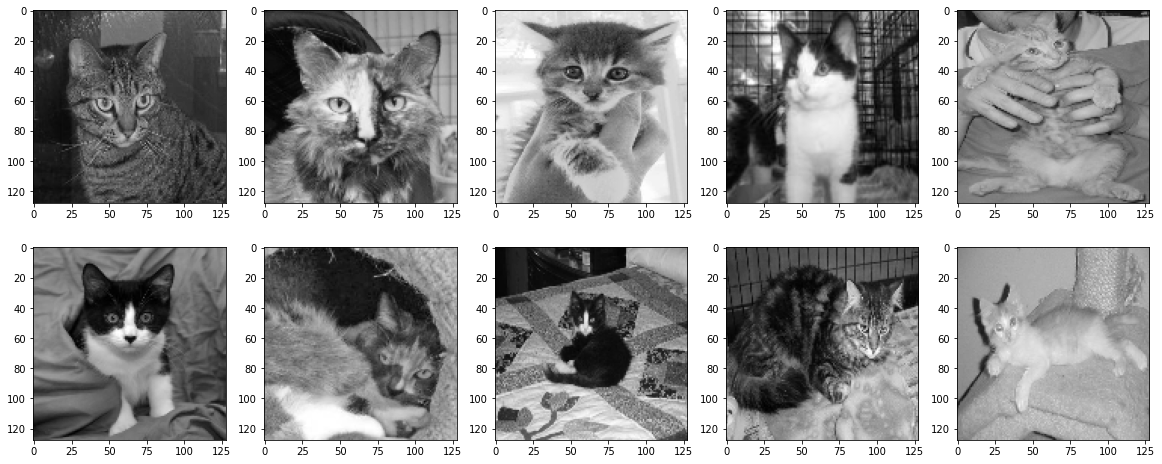

In [75]:
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(cat_img[i],cmap='gray', vmin=0, vmax=255)

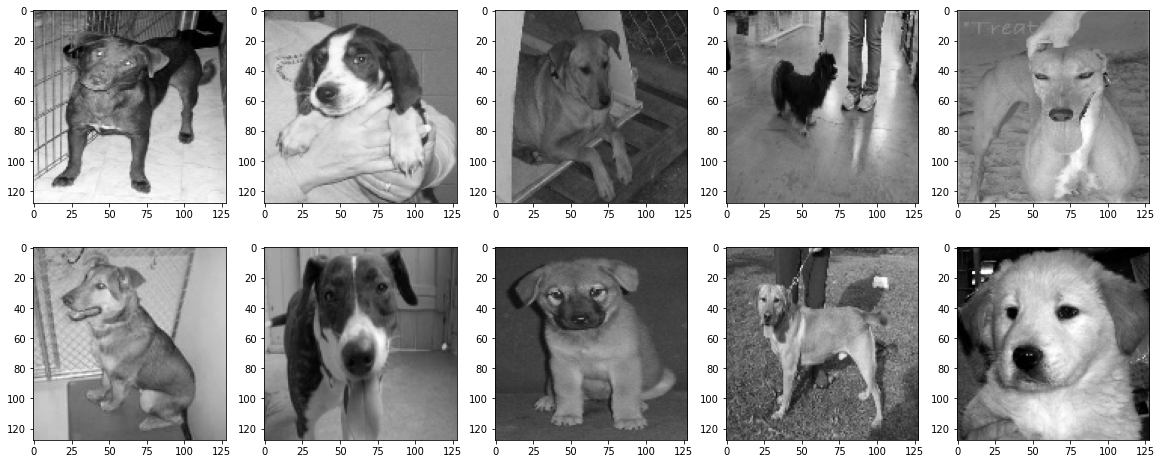

In [76]:
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(dog_img[i],cmap='gray', vmin=0, vmax=255)

In [77]:
X = np.vstack([cat_img,dog_img])

In [78]:
y = np.hstack([y_cat,y_dog])

In [79]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)

In [80]:
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([3189, 3215], dtype=int64))

In [81]:
np.unique(y_val, return_counts=True)

(array([0., 1.]), array([811, 790], dtype=int64))

In [82]:
y_train = np.expand_dims(y_train ,-1)

In [83]:
X_train.shape

(6404, 128, 128, 1)

In [84]:
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    classes=1,
    classifier_activation="softmax",
    input_shape=(128, 128, 3)
)

In [85]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [86]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
pred = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs = base_model.input, outputs = pred)

In [87]:

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                metrics = [tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC(curve='ROC')])

In [ ]:
history = model.fit(x=X_train,y=y_train, epochs=15, batch_size=64, validation_data=(X_val,y_val), shuffle=True)

Epoch 1/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 57s 470ms/step - auc_1: 0.8023 - binary_accuracy: 0.6326 - loss: 0.6266 - val_auc_1: 0.9595 - val_binary_accuracy: 0.8101 - val_loss: 0.4999
Epoch 2/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 43s 422ms/step - auc_1: 0.9551 - binary_accuracy: 0.8136 - loss: 0.4891 - val_auc_1: 0.9809 - val_binary_accuracy: 0.8976 - val_loss: 0.3975
Epoch 3/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 415ms/step - auc_1: 0.9767 - binary_accuracy: 0.8856 - loss: 0.3945 - val_auc_1: 0.9861 - val_binary_accuracy: 0.9257 - val_loss: 0.3260
Epoch 4/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 39s 386ms/step - auc_1: 0.9828 - binary_accuracy: 0.9204 - loss: 0.3258 - val_auc_1: 0.9885 - val_binary_accuracy: 0.9357 - val_loss: 0.2748
Epoch 5/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 417ms/step - auc_1: 0.9834 - binary_accuracy: 0.9283 - loss: 0.2817 - val_auc_1: 0.9898 - val_binary_accuracy: 0.9400 - val_loss: 0.2378
Epoch 6/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 381ms/step - auc_1: 0.9877 - binary_accuracy: 0.941

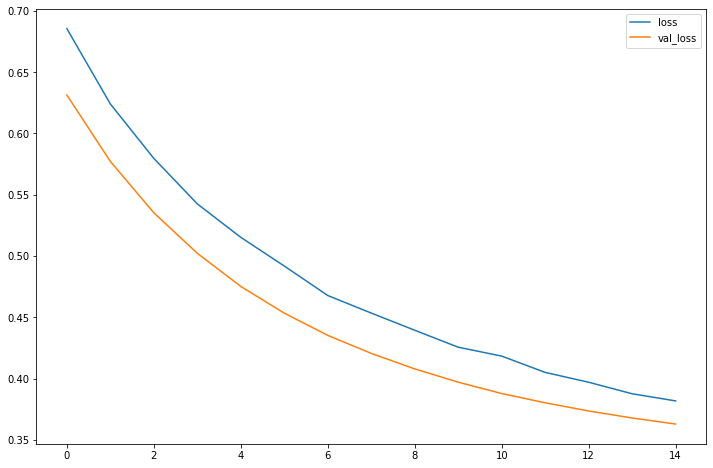

In [26]:
plt.figure(figsize=(12,8))
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

In [27]:
history.history.keys()

dict_keys(['auc', 'binary_accuracy', 'loss', 'val_auc', 'val_binary_accuracy', 'val_loss'])

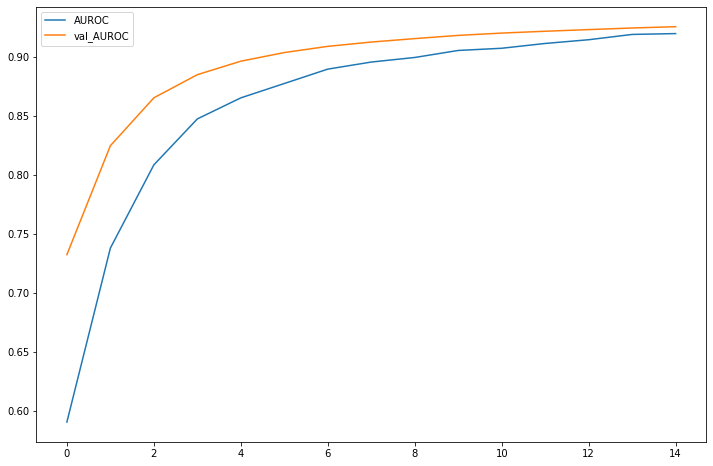

In [61]:
plt.figure(figsize=(12,8))
plt.plot(history.history["auc"], label="AUROC")
plt.plot(history.history["val_auc"], label="val_AUROC")
plt.legend()
plt.show()

In [29]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [55]:
from IPython.display import Image, display
import matplotlib as mpl
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=1.0):
    # Load the original image


    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["Reds"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)


    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    plt.imshow(superimposed_img)


In [56]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 64, 64, 3)         │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_1               │ (None, 64, 64, 3)         │               0 │ rescaling_1[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 32, 32, 32)        │             864 │ normalization_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 32, 32, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 32, 32, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 32, 32, 16)        │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 32, 32, 16)        │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 32, 32, 16)        │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 16, 16, 64)        │           9,216 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_bn             │ (None, 16, 16, 64)        │             256 │ block2a_expand_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_activation     │ (None, 16, 16, 64)        │               0 │ block2a_expand_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_conv (Conv2D) │ (None, 16, 16, 32)        │           2,048 │ block2a_expand_activation… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_bn            │ (None, 16, 16, 32)        │             128 │ block2a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 6,411,605 (24.46 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 328,196 (1.25 MB)

In [57]:
# GradCam - lokal forklaring - spesifikt for CNN modeller

In [65]:
img_indx = 6
heat_map = make_gradcam_heatmap(X_val[img_indx:img_indx+1], model, "stem_conv", pred_index=None)

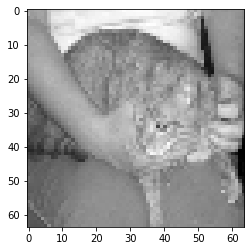

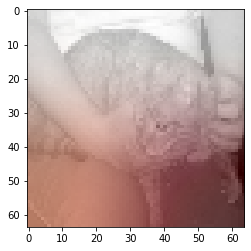

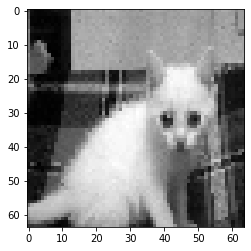

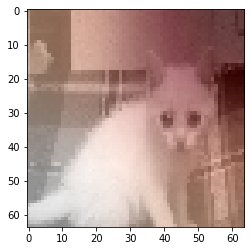

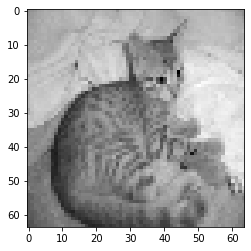

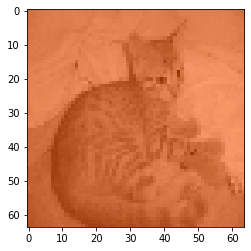

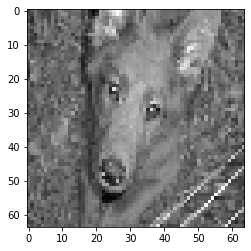

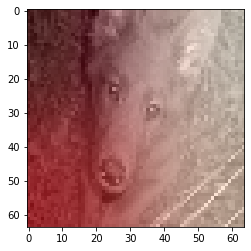

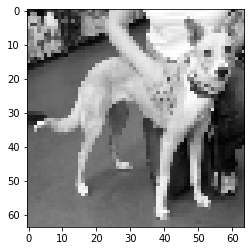

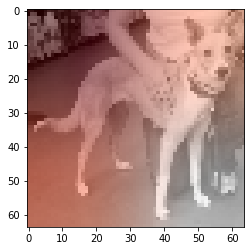

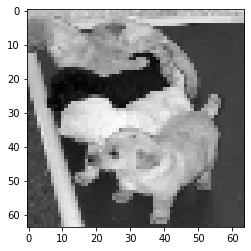

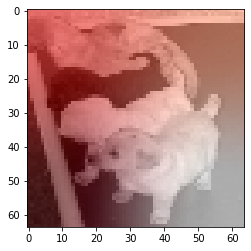

In [66]:
for img_indx in range(6):
    heat_map = make_gradcam_heatmap(X_val[img_indx:img_indx+1], model, "top_conv", pred_index=None)
    plt.figure()
    plt.imshow( tf.keras.utils.array_to_img(X_val[img_indx]),cmap='gray')
    plt.show()
    save_and_display_gradcam(X_val[img_indx],heat_map)